In [103]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import v2
from torchvision import tv_tensors
from torchvision.io import decode_image
import torchvision.models as models
from torchvision.ops import generalized_box_iou_loss
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

from tqdm.auto import tqdm
import requests
import zipfile
import pathlib
from pathlib import Path
import shutil
import os
import pandas as pd
import numpy as np
import random
from PIL import Image
from sklearn.model_selection import StratifiedGroupKFold
from typing import Tuple, Dict, List
import sys
from timeit import default_timer as timer

# %load_ext autoreload
# %autoreload 1
# %aimport CarImageClass
import CarImageClass

device = "cuda" if torch.cuda.is_available() else "cpu"

# desktop or laptop
machine = 'laptop'

# Setup path to data folder
if machine == 'laptop':
    folder_path = Path(r"C:\self-driving-car\data")
else:
    folder_path = Path(r"D:\Udacity_car_data\data")

train_path = folder_path / "train"
test_path = folder_path / "test"
train_path_simple = folder_path / "train_simple"
test_path_simple = folder_path / "test_simple"
train_path_oo = folder_path / "train_one_obj"
test_path_oo = folder_path / "test_one_obj"

IMG_SIZE = 224

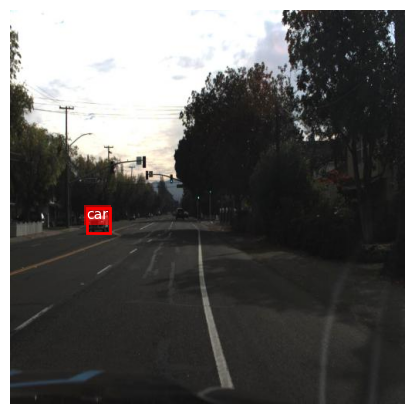

In [104]:
train_data = CarImageClass.ImageClass(targ_dir=train_path_oo, transform=None, file_pct=0.5)

train_data.show_with_box(index=0, color='r', label=True)

In [105]:
class SingleBoxResNet18(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
        in_feats = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Linear(in_feats, 256), nn.ReLU(inplace=True),
            nn.Linear(256, 4)
        )
        # predict normalized 0..1 via sigmoid; scale to pixels -> strictly inside image
        # this guarantees valid extent after sorting
    def forward(self, x):
        out = self.backbone(x).sigmoid()        # (B,4) in [0,1]
        out = out * IMG_SIZE                    # pixels
        # enforce (x1<=x2, y1<=y2)
        x1, y1, x2, y2 = out.unbind(-1)
        x_min = torch.minimum(x1, x2)
        y_min = torch.minimum(y1, y2)
        x_max = torch.maximum(x1, x2)
        y_max = torch.maximum(y1, y2)
        return torch.stack([x_min, y_min, x_max, y_max], dim=-1)

In [106]:
# random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# transforms
train_tfms = v2.Compose([
    v2.ToImage(),                                 # uint8 -> Tensor[C,H,W]
    v2.ToDtype(torch.float32, scale=True),        # to float in [0,1]
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPhotometricDistort(p=0.5),
    v2.Resize((IMG_SIZE, IMG_SIZE)),                        # pick a fixed size for batching
    v2.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

test_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((IMG_SIZE, IMG_SIZE)),
    v2.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# training/testing data
train_data = CarImageClass.ImageClass(targ_dir=train_path_oo, transform=train_tfms, file_pct=0.25)
test_data = CarImageClass.ImageClass(targ_dir=test_path_oo, transform=test_tfms, file_pct=0.25)


BATCH_SIZE = 16
# Create DataLoader's
train_dataloader = DataLoader(train_data, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, 
                              #num_workers=NUM_WORKERS,
                              )

test_dataloader = DataLoader(test_data, 
                             batch_size=BATCH_SIZE, 
                             shuffle=False, 
                             #num_workers=NUM_WORKERS,
                             )

model_0 = SingleBoxResNet18().to(device)

In [107]:
image_batch, target_batch = next(iter(train_dataloader))

m0test = model_0(image_batch.to(device))

m0test[5]

tensor([124.3334,  89.9319, 138.1929, 108.4886], grad_fn=<SelectBackward0>)

In [108]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
    
    # put model in train mode
    model.train()

    # train loss, train accuracy values
    train_loss, train_acc = 0, 0

    # loop through data loader batches
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        for key in y.keys():
            y[key] = y[key].to(device)

        # forward pass
        B, _, H, W = X.shape
        y_pred = model(X)

        # calculate loss
        loss = loss_fn(y_pred, y['boxes'].squeeze())
        train_loss += loss.item()

        # Optimizer zero grad
        optimizer.zero_grad(set_to_none=True)

        # loss backward
        loss.backward()

        # optimizer step
        optimizer.step()

        # calculate accuracy metric
        # y_pred_class = 
        # train_acc += (y_pred_class==y).sum().item()/(len(y_pred))

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

##############################

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
    # put model in eval mode
    model.eval()

    # test loss, test acc
    test_loss = 0
    test_acc = 0

    # turn on inference mode
    with torch.inference_mode():
        # loop through dataloader batches
        for batch, (X, y) in enumerate(dataloader):
            # send data to device
            X = X.to(device)
            for key in y.keys():
                y[key] = y[key].to(device)

            # forward pass
            B, _, H, W = X.shape
            test_pred = model(X)

            # calculate loss
            loss = loss_fn(test_pred, y['boxes'].squeeze())
            test_loss += loss.item()

            # calculate accuracy
            # test_pred_labels = ??
            # test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)
    
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

##############################

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          # scheduler: torch.optim.lr_scheduler,
          loss_fn: torch.nn.Module,
          epochs: int = 5,
          device=device):
    
    # create results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                dataloader=train_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                device=device)
        
        test_loss, test_acc = test_step(model=model,
                                dataloader=test_dataloader,
                                loss_fn=loss_fn,
                                device=device)
        
        # if scheduler is not None:
        #     scheduler.step()
        
        print(f"Epoch: {epoch}  |  Train loss: {train_loss:.4f}  |  Train accuracy: {train_acc:.4f}  |  Test loss: {test_loss:.4f}  |  Test accuracy: {test_acc:.4f}  ")

        # update results dictionary
        results['train_loss'].append(train_loss)
        results['test_loss'].append(test_loss)

    # return results
    return results

In [109]:
# random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# transforms
train_tfms = v2.Compose([
    v2.ToImage(),                                 # uint8 -> Tensor[C,H,W]
    v2.ToDtype(torch.float32, scale=True),        # to float in [0,1]
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPhotometricDistort(p=0.5),
    v2.Resize((IMG_SIZE, IMG_SIZE)),                        # pick a fixed size for batching
    v2.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

test_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((IMG_SIZE, IMG_SIZE)),
    v2.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# training/testing data
train_data = CarImageClass.ImageClass(targ_dir=train_path_oo, transform=train_tfms, file_pct=0.25)
test_data = CarImageClass.ImageClass(targ_dir=test_path_oo, transform=test_tfms, file_pct=0.25)


BATCH_SIZE = 16
# Create DataLoader's
train_dataloader = DataLoader(train_data, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, 
                              #num_workers=NUM_WORKERS,
                              )

test_dataloader = DataLoader(test_data, 
                             batch_size=BATCH_SIZE, 
                             shuffle=False, 
                             #num_workers=NUM_WORKERS,
                             )

# number of epochs
NUM_EPOCHS = 50

# model instantiation
# model_0 = SingleBoxRegressor(pixel_count=pix_count).to(device)
model_0 = SingleBoxResNet18().to(device)

# setup loss function
loss_fn = nn.L1Loss()
optimizer = torch.optim.AdamW(params=model_0.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

# start timer
start_time = timer()

# train model 0

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        # scheduler=None,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# end timer and print
end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0  |  Train loss: 24.9479  |  Train accuracy: 0.0000  |  Test loss: 21.9952  |  Test accuracy: 0.0000  
Epoch: 1  |  Train loss: 20.7003  |  Train accuracy: 0.0000  |  Test loss: 19.5173  |  Test accuracy: 0.0000  
Epoch: 2  |  Train loss: 18.0710  |  Train accuracy: 0.0000  |  Test loss: 19.5059  |  Test accuracy: 0.0000  
Epoch: 3  |  Train loss: 14.4867  |  Train accuracy: 0.0000  |  Test loss: 15.9694  |  Test accuracy: 0.0000  
Epoch: 4  |  Train loss: 13.4396  |  Train accuracy: 0.0000  |  Test loss: 15.3948  |  Test accuracy: 0.0000  
Epoch: 5  |  Train loss: 12.8416  |  Train accuracy: 0.0000  |  Test loss: 14.9402  |  Test accuracy: 0.0000  
Epoch: 6  |  Train loss: 12.2381  |  Train accuracy: 0.0000  |  Test loss: 14.4946  |  Test accuracy: 0.0000  
Epoch: 7  |  Train loss: 12.8871  |  Train accuracy: 0.0000  |  Test loss: 12.9577  |  Test accuracy: 0.0000  
Epoch: 8  |  Train loss: 10.7934  |  Train accuracy: 0.0000  |  Test loss: 12.3893  |  Test accuracy: 0.0000  
E

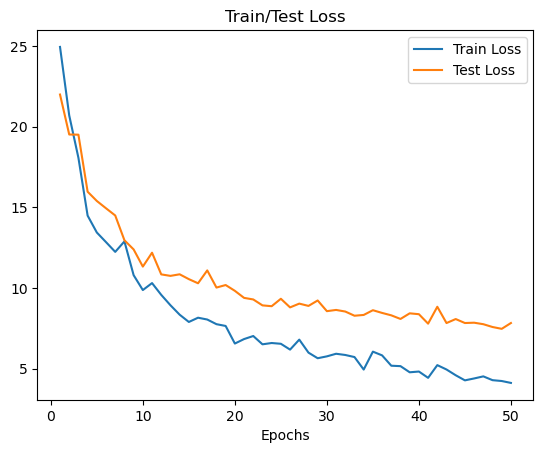

In [110]:
plt.plot(range(1, 1+NUM_EPOCHS), model_0_results["train_loss"], label="Train Loss")
plt.plot(range(1, 1+NUM_EPOCHS), model_0_results["test_loss"], label="Test Loss")
plt.title("Train/Test Loss")
plt.xlabel("Epochs")
plt.legend()

plt.show()

In [113]:
def show_with_box(img_plus_target,
                  color: str = "C0",
                  lw: int = 2,
                  label: bool = False,
                  pred_box: bool = False,
                  bbox_pred: torch.Tensor = torch.zeros((1,4))
                  ):
        
        # convert the image to a numpy array
        img, target = img_plus_target

        if isinstance(img, Image.Image):
            arr = np.array(img)
        elif isinstance(img, np.ndarray):
            arr = img
            if arr.ndim == 3 and arr.shape[0] in (1, 3) and arr.shape[2] not in (1, 3):
                arr = np.transpose(arr, (1, 2, 0))
        elif isinstance(img, torch.Tensor):
            t = img.detach().cpu()
            if t.ndim == 3 and t.shape[0] in (1, 3):  # CHW -> HWC
                t = t.permute(1, 2, 0)
            arr = t.numpy()
        else:
            raise TypeError(f"Unsupported image type: {type(img)}")

        if arr.dtype.kind == "f" and arr.max() <= 1.0:
            arr = (arr * 255.0).clip(0, 255).astype(np.uint8)
        elif arr.dtype != np.uint8:
            arr = arr.astype(np.uint8)
        

        # plot image
        H, W = arr.shape[:2]
        dpi = 100
        fig, ax = plt.subplots(figsize=(W/dpi*2, H/dpi*2), dpi=dpi)
        ax.imshow(arr)  # origin='upper' -> y downward, matches image coords

        for i in range(len(target['labels'])):

            # basic sanity + clipping
            x_min = target['boxes'][i, 0]
            y_min = target['boxes'][i, 1]
            x_max = target['boxes'][i, 2]
            y_max = target['boxes'][i, 3]
            x_min, y_min = max(0.0, x_min), max(0.0, y_min)
            x_max, y_max = min(W - 1, x_max), min(H - 1, y_max)
            if not (x_max > x_min and y_max > y_min):
                # raise ValueError("Degenerate or inverted box after clipping.")
                continue

            
            rect = Rectangle(
                (x_min, y_min),
                x_max - x_min,
                y_max - y_min,
                linewidth=lw,
                edgecolor=color,
                facecolor="none",
            )
            ax.add_patch(rect)
            if label:
                im_label_masked = target['labels'][i]
                im_label = list(self.class_to_idx.keys())[list(self.class_to_idx.values()).index(im_label_masked)]
                ax.text(
                    x_min, y_min,
                    str(im_label),
                    fontsize=10,
                    color="white",
                    va="top",
                    ha="left",
                    bbox=dict(facecolor=color, alpha=0.6, pad=2, edgecolor="none"),
                )
        
        if pred_box == True:
            for i in range(len(bbox_pred)):
                x_min = bbox_pred[i, 0]
                y_min = bbox_pred[i, 1]
                x_max = bbox_pred[i, 2]
                y_max = bbox_pred[i, 3]
                x_min, y_min = max(0.0, x_min), max(0.0, y_min)
                x_max, y_max = min(W - 1, x_max), min(H - 1, y_max)
                if not (x_max > x_min and y_max > y_min):
                    # raise ValueError("Degenerate or inverted box after clipping.")
                    continue

                
                rect = Rectangle(
                    (x_min, y_min),
                    x_max - x_min,
                    y_max - y_min,
                    linewidth=lw,
                    edgecolor='g',
                    facecolor="none",
                )
                ax.add_patch(rect)
        
        ax.axis("off")

        plt.close(fig)
        return fig

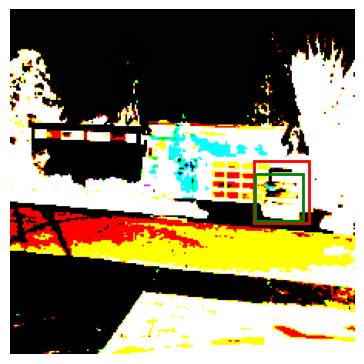

In [134]:
new_imgs = CarImageClass.ImageClass(targ_dir=train_path_oo, transform=train_tfms, file_pct=0.1)

BATCH_SIZE = 1
# Create DataLoader's
new_dataloader = DataLoader(new_imgs, 
                              batch_size=BATCH_SIZE, 
                              shuffle=False, 
                              #num_workers=NUM_WORKERS,
                              )

new = new_dataloader.dataset[33]

predbox = model_0(new[0].unsqueeze(dim=0)).detach()

show_with_box(new, color='r', label=False, pred_box=True, bbox_pred=predbox)